# Generic LA tool

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from src.dlla.hw import dlla_p_gradient, prepare_traces_dl
from src.dlla.berg import make_mlp
from src.dlla.wegener import make_mlp_wegener, wegener_p_gradient
from src.pollution.tools import file_suffix
from src.tools.cache import cache_np
from src.tools.la import fixed_fixed
from src.tools.plotter import init_plots, plot_p_gradient, PALETTE_GRADIENT, store_sns, TVLA_PALETTE, DLLA_PALETTE
from src.trace_set.database import Database
from src.trace_set.set_hw import TraceSetHW
from src.tvla.cri import tvla_t_test, rho_test
from src.tvla.tvla import prune, ASCAD_DEAD_TRACES, prepare_tvla

from src.trace_set.transform import reduce_fixed_fixed

init_plots()

In [3]:
# EDIT This line for other databases.
DB = Database.ascad_none

# ---
TRACE_SET = TraceSetHW(DB)

POLLUTION_TYPE = None
FILE_SUFFIX = file_suffix(POLLUTION_TYPE, 0)

NUM_CLASSES = 9
Y_LIM = 10 ** -40

TRACES_NAME = ""
LIMIT = 100000
if DB is Database.aisy:
    TRACES_NAME = "AISy lab traces"
    LIMIT = 5000
elif DB is Database.ascad_none:
    TRACES_NAME = "ASCAD unprotected traces"
elif DB is Database.ascad:
    TRACES_NAME = "ASCAD masked traces"

In [4]:
REPEAT_DLLA = 30
REPEAT_TVLA = 100
if DB is Database.aisy:
    REPEAT_TVLA = 300

In [5]:
PROF_X, PROF_Y = TRACE_SET.profile()

In [6]:
PVS_T = tvla_t_test(*fixed_fixed(PROF_X, PROF_Y), progress=True)

Computing Central Moments: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


In [7]:
np.min(PVS_T[1])

0.030436244660139375

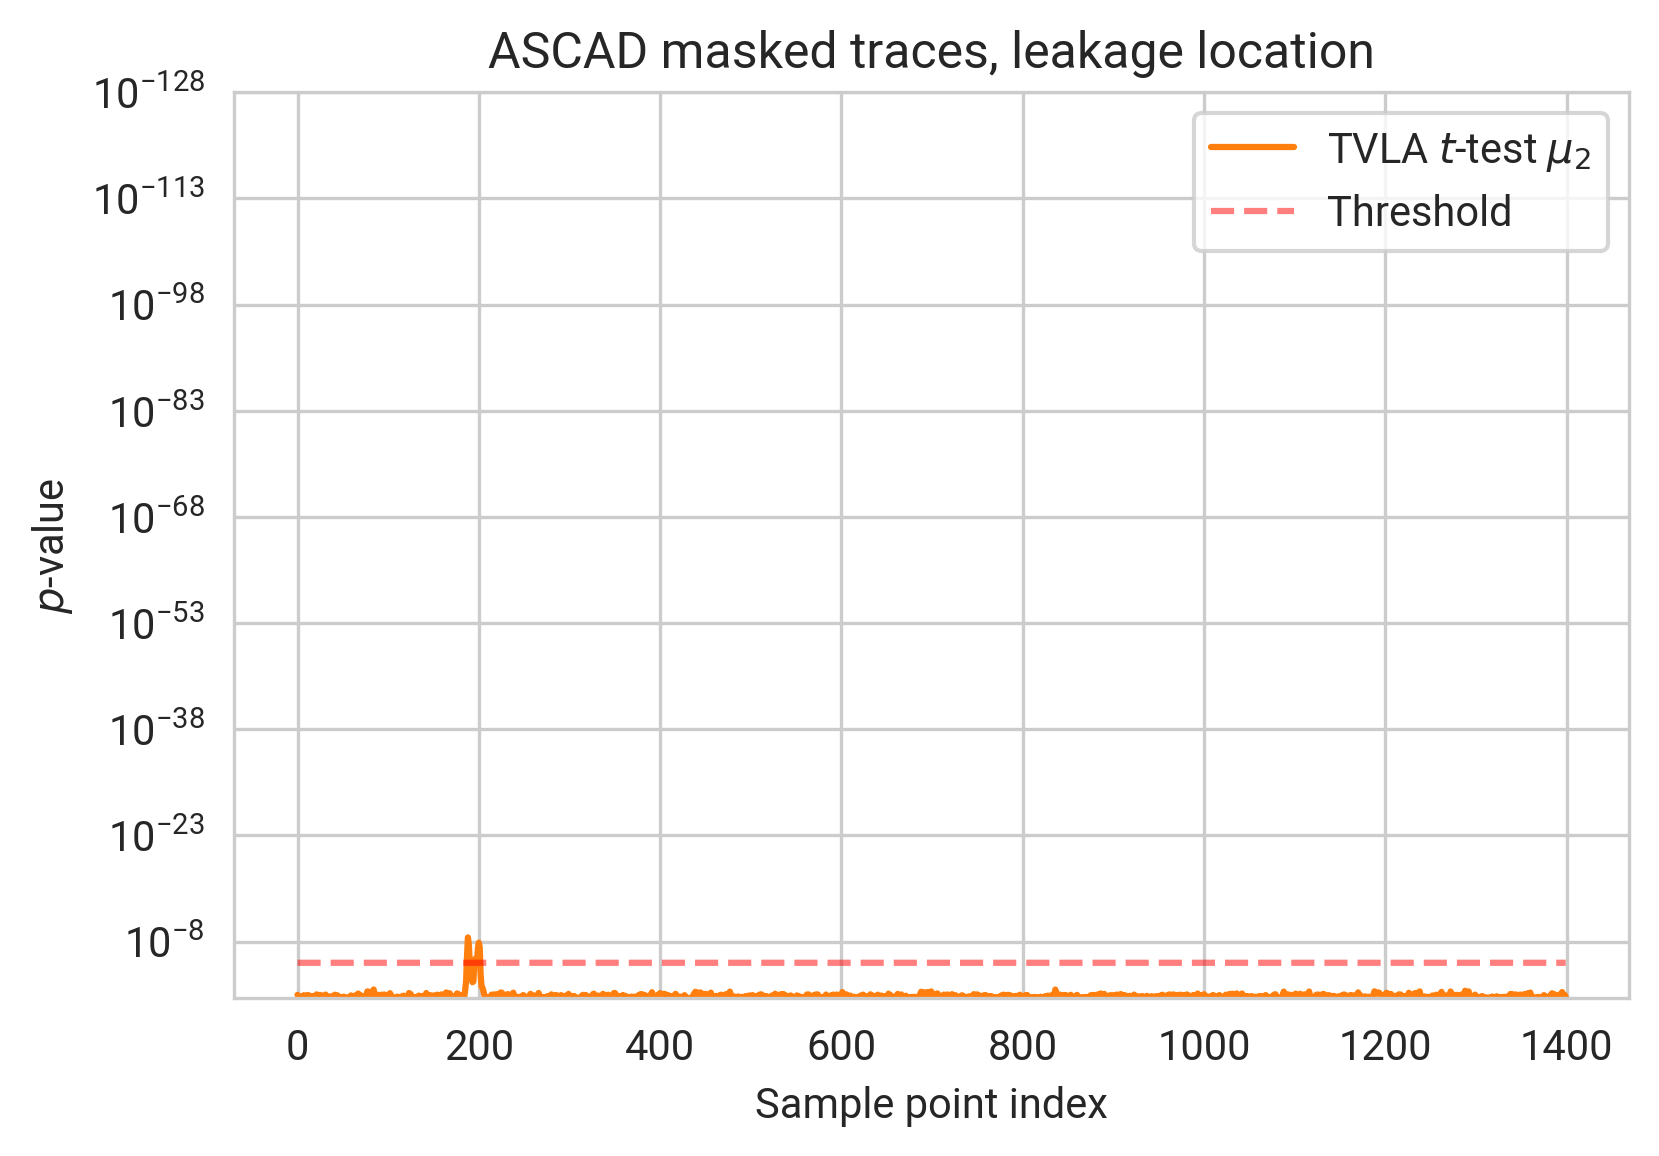

In [8]:
ORDER = 1 + (DB == Database.ascad)

G = sns.lineplot(data={f"TVLA $t$-test $\mu_{ORDER}$": PVS_T[ORDER]}, palette=[TVLA_PALETTE[-1]])
sns.lineplot(data= [10 ** -5] * len(PVS_T[ORDER]), color="#FF000080", linestyle="--", label="Threshold")
G.invert_yaxis()
G.set(yscale="log", ylabel="$p$-value", xlabel="Sample point index", title=f"{TRACES_NAME}, leakage location", ylim=(10 ** 0, 10 ** -128))
store_sns(G, f"{DB.name}-pvs-t-{FILE_SUFFIX}")

In [9]:
np.min(PVS_T)

2.608136648466456e-09

In [10]:
WINDOW_SIZE = PROF_X.shape[1]
TITLE_SUB = f"{TRACES_NAME} with {WINDOW_SIZE} sample points"

In [11]:
def point_ixs(num_traces, min_traces=2, num_points=200, small_sample=1000):
    # Large-scale point indexes (all traces)
    point_ix_lg = np.linspace(min_traces, num_traces, num_points).astype(int)
    # Small-scale point indexes (first traces)
    point_ix_sm = np.linspace(min_traces, min(num_traces, small_sample), num_points).astype(int)

    return np.union1d(point_ix_sm, point_ix_lg)

In [12]:

def shuffle(x, y):
    ix = np.arange(len(x))
    np.random.shuffle(ix)

    return x[ix], y[ix]

def single_tvla_t_pg(x, y, min_pvs, order):
    min_sp = min_pvs.argmin()

    num_traces = len(x)
    x_lim = np.array(x[:, min_sp:min_sp + 1])
    ixs = point_ixs(num_traces)
    pvs = np.ones(ixs.shape)

    for ix, limit in enumerate(ixs):
        pvs[ix] = np.min(tvla_t_test(x_lim[:limit], y[:limit], order, progress=False)[order])

    return np.interp(np.arange(num_traces), ixs, pvs)

def tvla_t_p_gradient(x, y, min_pvs, order, times=REPEAT_TVLA):
    res = []
    for _ in tqdm(range(times), "TVLA t-test p-gradient"):
        res.append(single_tvla_t_pg(*shuffle(x, y), min_pvs, order))

    return np.median(res, axis=0)

LIM_MASK = np.ones(len(PROF_X)).astype(bool)

if DB is Database.ascad:
    LIM_MASK[94463] = False
    print(PROF_Y[94463])

3


In [13]:
PG2 = tvla_t_p_gradient(PROF_X[LIM_MASK], PROF_Y[LIM_MASK], PVS_T[2], 2, 1)

TVLA t-test p-gradient: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


In [14]:
TVLA_X, TVLA_Y = prepare_tvla(PROF_X, PROF_Y)
TVLA_X_LIM, TVLA_Y_LIM = prepare_tvla(PROF_X[LIM_MASK], PROF_Y[LIM_MASK])

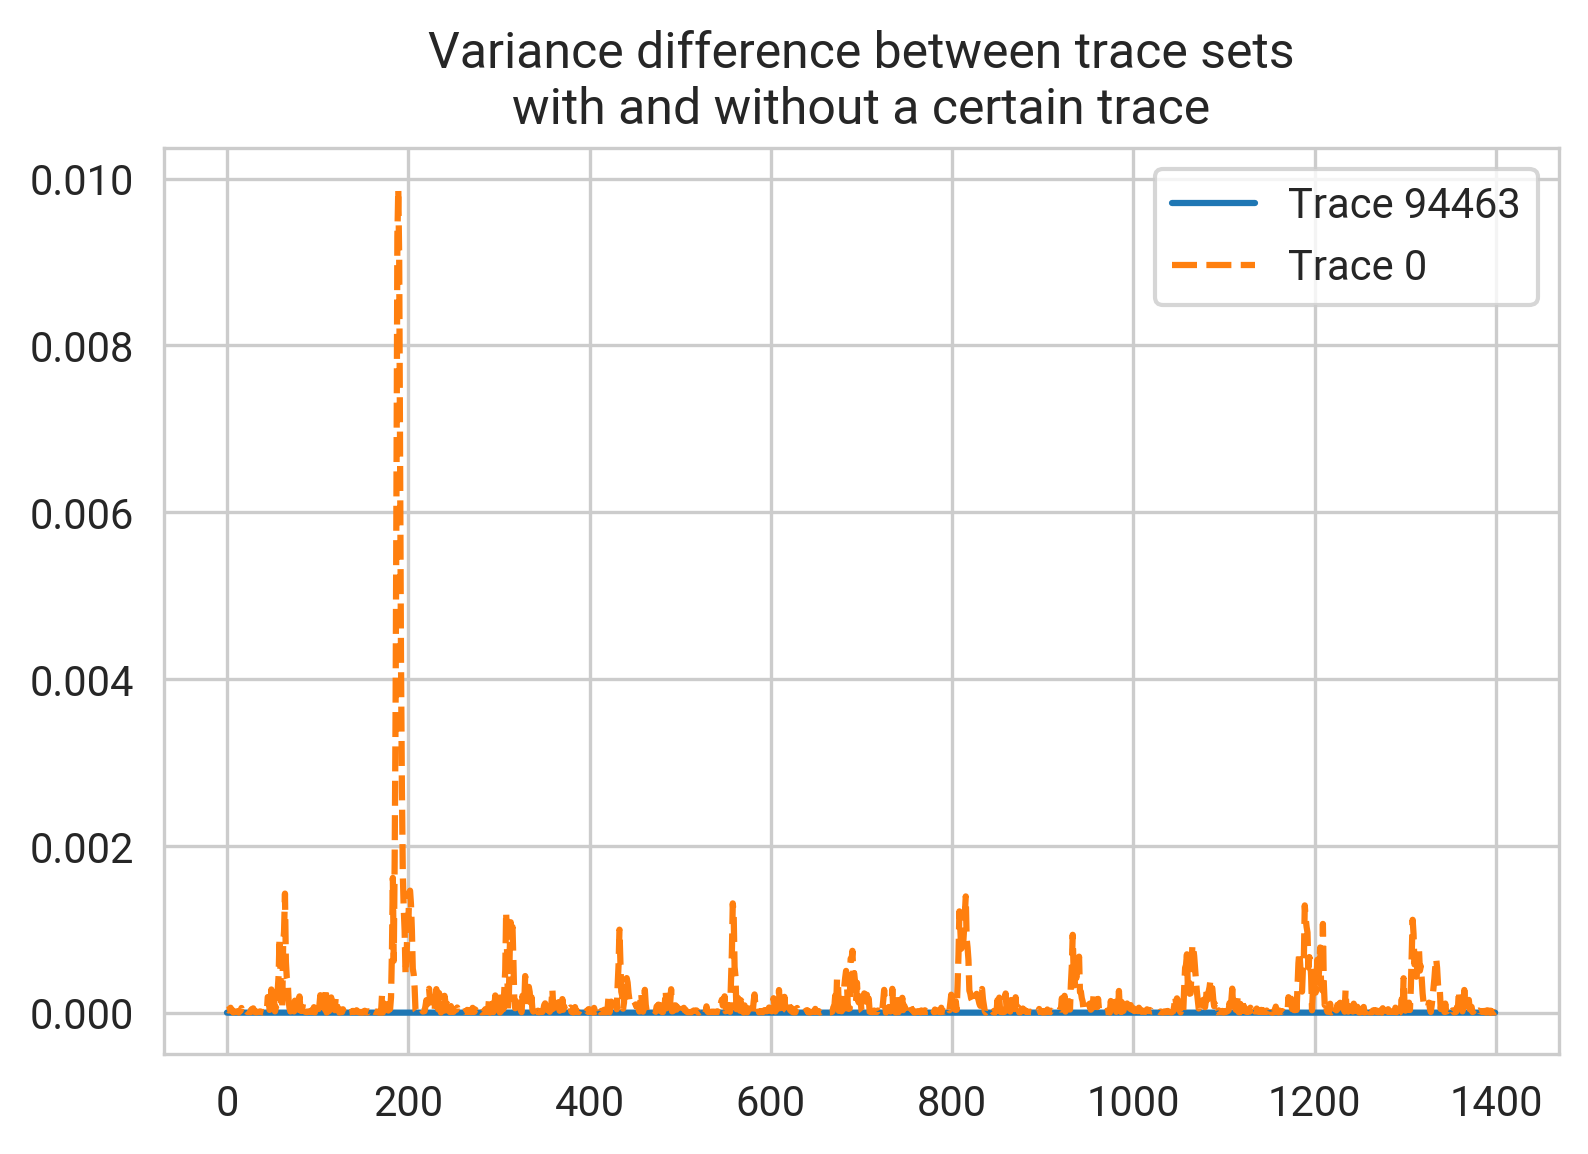

In [15]:
if DB is Database.ascad:
    HIGH = TVLA_X[TVLA_Y]
    HIGH_LIM = TVLA_X_LIM[TVLA_Y_LIM]

    def with_and_without(b):
        num_traces = len(b)
        res = np.zeros(num_traces)
        variance_all = b.var()

        for ix in tqdm(range(num_traces)):
            mask = np.ones(num_traces).astype(bool)
            mask[ix] = False
            var_diff = np.abs(b[mask].var() - variance_all)
            res[ix] = var_diff

        return res

    ALL = cache_np("with_and_without", with_and_without, HIGH[:, np.argmin(PVS_T[2])])

    MASK_LIM_TOP_2 = np.ones(len(HIGH_LIM)).astype(bool)
    MASK_LIM_TOP_2[ALL.argsort()[-2]] = False

    # It's in B!
    G = sns.lineplot(data={"Trace 94463": abs(HIGH_LIM.var(axis=0) - HIGH.var(axis=0)), "Trace 0": abs(HIGH_LIM[MASK_LIM_TOP_2].var(axis=0) - HIGH_LIM.var(axis=0))})
    G.set(title="Variance difference between trace sets\nwith and without a certain trace")

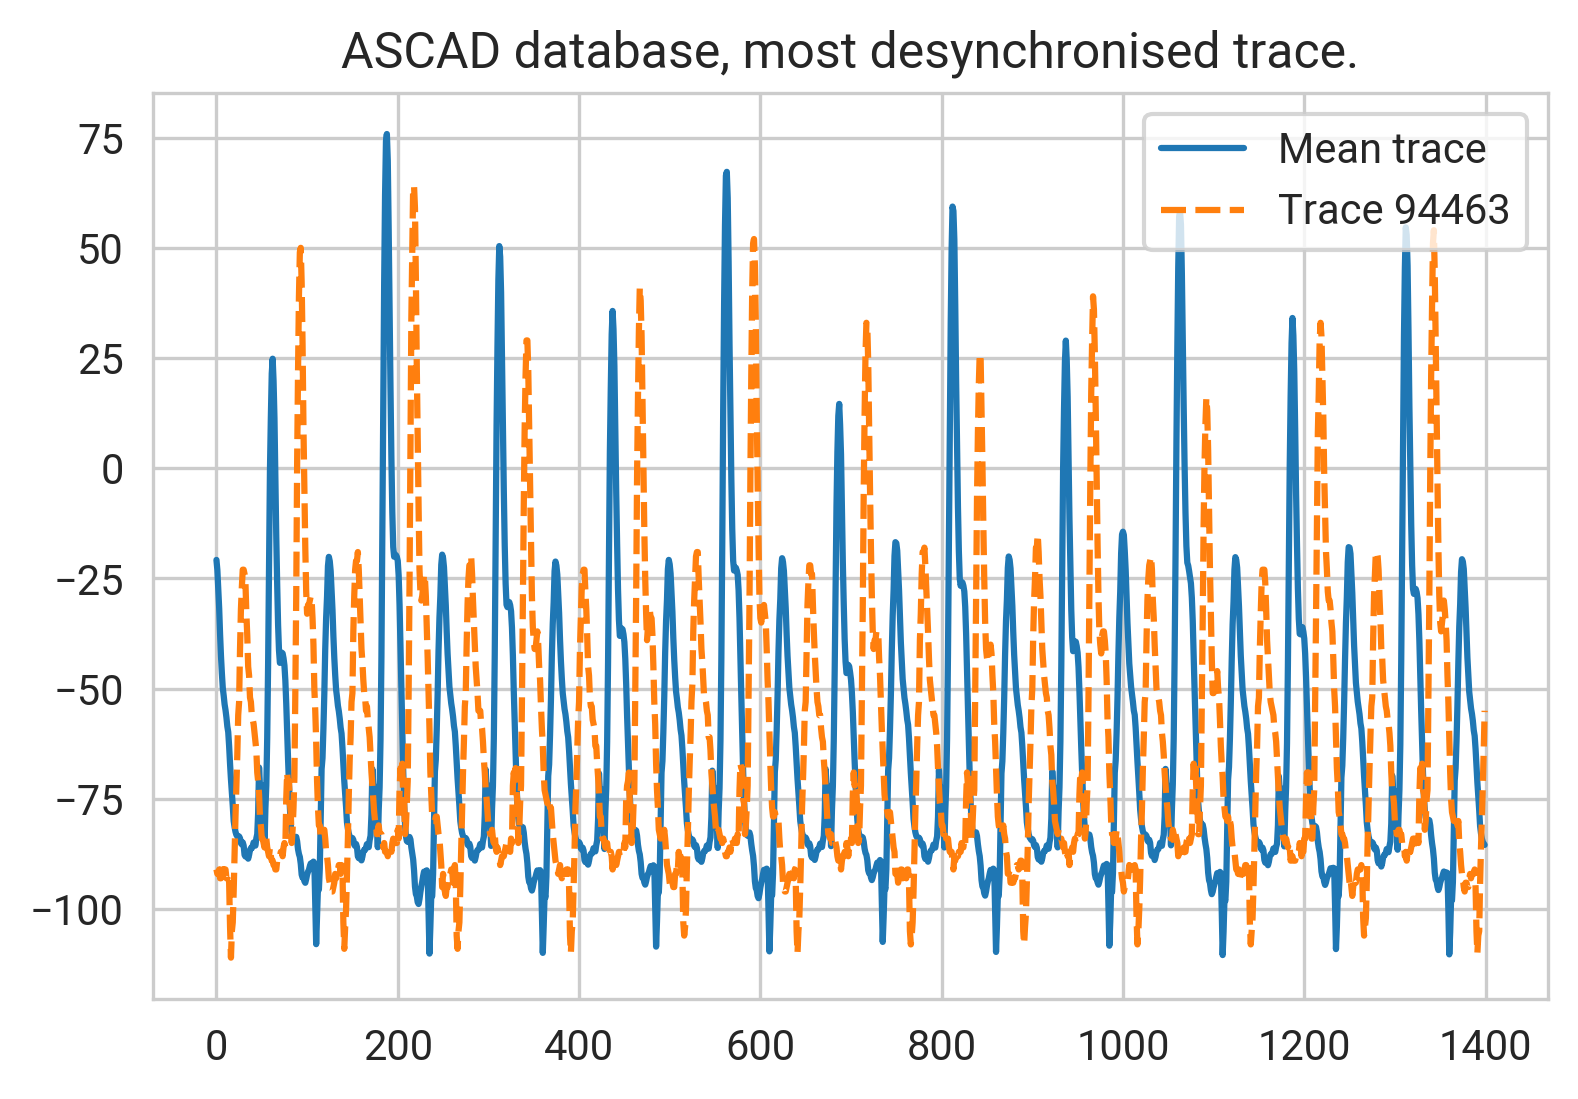

In [16]:
if DB is Database.ascad:
    G = sns.lineplot(data={"Mean trace": np.mean(PROF_X[LIM_MASK], axis=0), "Trace 94463": PROF_X[94463]})
    G.set(title="ASCAD database, most desynchronised trace.")
    store_sns(G, "ascad-anomalous-trace")

In [17]:
PVS_T = tvla_t_test(TVLA_X_LIM, TVLA_Y_LIM, progress=True)

TVLA_PG_T_1 = cache_np(f"{DB.name}-tvla-t-1", tvla_t_p_gradient, TVLA_X_LIM, TVLA_Y_LIM, PVS_T[1], 1)
TVLA_PG_T_2 = cache_np(f"{DB.name}-tvla-t-2", tvla_t_p_gradient, TVLA_X_LIM, TVLA_Y_LIM, PVS_T[2], 2)
TVLA_PG_T_3 = cache_np(f"{DB.name}-tvla-t-3", tvla_t_p_gradient, TVLA_X_LIM, TVLA_Y_LIM, PVS_T[3], 3)

Computing Central Moments: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


In [18]:
if DB is Database.ascad:
    PVS_T_WITH = tvla_t_test(TVLA_X, TVLA_Y, progress=True)

    TVLA_PG_T_1_WITH = cache_np(f"{DB.name}-tvla-t-1-with", tvla_t_p_gradient, TVLA_X, TVLA_Y, PVS_T[1], 1)
    TVLA_PG_T_2_WITH = cache_np(f"{DB.name}-tvla-t-2-with", tvla_t_p_gradient, TVLA_X, TVLA_Y, PVS_T[2], 2)
    TVLA_PG_T_3_WITH = cache_np(f"{DB.name}-tvla-t-3-with", tvla_t_p_gradient, TVLA_X, TVLA_Y, PVS_T[3], 3)

Computing Central Moments: 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]


In [19]:
def single_tvla_rho_pg(x, y, min_pvs):
    min_sp = min_pvs.argmin()

    num_traces = len(x)
    x_lim = np.array(x[:, min_sp:min_sp + 1])
    ixs = point_ixs(num_traces)
    pvs = np.ones(ixs.shape)

    for ix, limit in enumerate(ixs):
        pvs[ix] = np.min(rho_test(x_lim[:limit], y[:limit], progress=False))

    return np.interp(np.arange(num_traces), ixs, pvs)

def tvla_rho_p_gradient(x, y, min_pvs, times=REPEAT_TVLA):
    res = []
    for _ in tqdm(range(times), "TVLA rho-test p-gradient"):
        res.append(single_tvla_rho_pg(*shuffle(x, y), min_pvs))

    return np.median(res, axis=0)

In [20]:
PVS_RHO = rho_test(TVLA_X_LIM, TVLA_Y_LIM, progress=True)[0]
TVLA_PG_RHO = cache_np(f"{DB.name}-tvla-rho", tvla_rho_p_gradient, TVLA_X_LIM, TVLA_Y_LIM, PVS_RHO)

Computing Correlation Coefficients: 100%|██████████| 1400/1400 [00:01<00:00, 1271.65it/s]


/home/berg/anaconda3/envs/LA/lib/python3.9/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


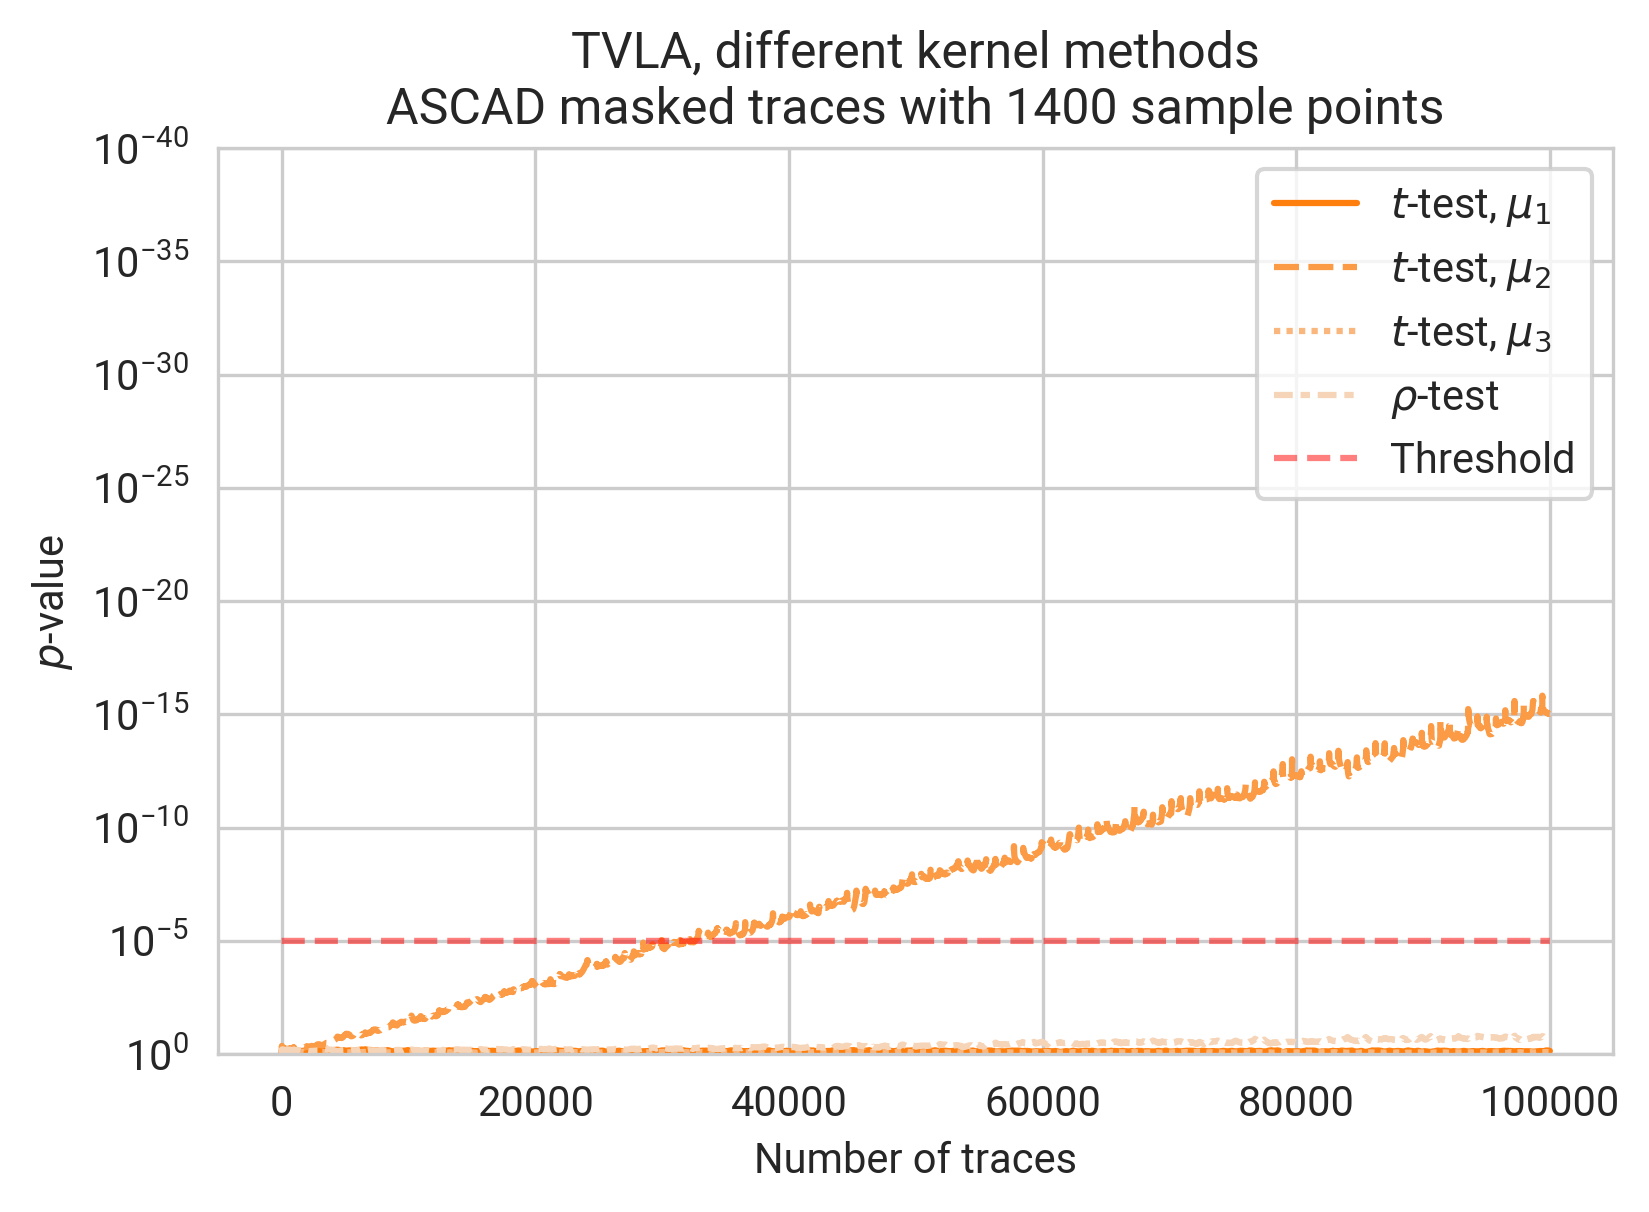

In [21]:
G = sns.lineplot(data={"$t$-test, $\mu_1$": TVLA_PG_T_1[:LIMIT], "$t$-test, $\mu_2$": TVLA_PG_T_2[:LIMIT], "$t$-test, $\mu_3$": TVLA_PG_T_3[:LIMIT], "$\\rho$-test": TVLA_PG_RHO[:LIMIT]}, palette=np.array(TVLA_PALETTE)[[4, 3, 2, 1]])
sns.lineplot(data=[10 ** -5] * LIMIT, color="#FF000080", linestyle="--", label="Threshold")

G.set(yscale='log', ylim=(1, Y_LIM), xlabel="Number of traces", ylabel="$p$-value", title=f"TVLA, different kernel methods\n{TITLE_SUB}") #, xlim=(94314,94320))
store_sns(G, f"{DB.name}-tvla")

In [22]:
X, Y, X_ATT, Y_ATT = prepare_traces_dl(PROF_X, PROF_Y, *TRACE_SET.attack())

Y_RAND, Y_ATT_RAND = Y.copy(), Y_ATT.copy()
np.random.shuffle(Y_RAND), np.random.shuffle(Y_ATT_RAND)

(None, None)

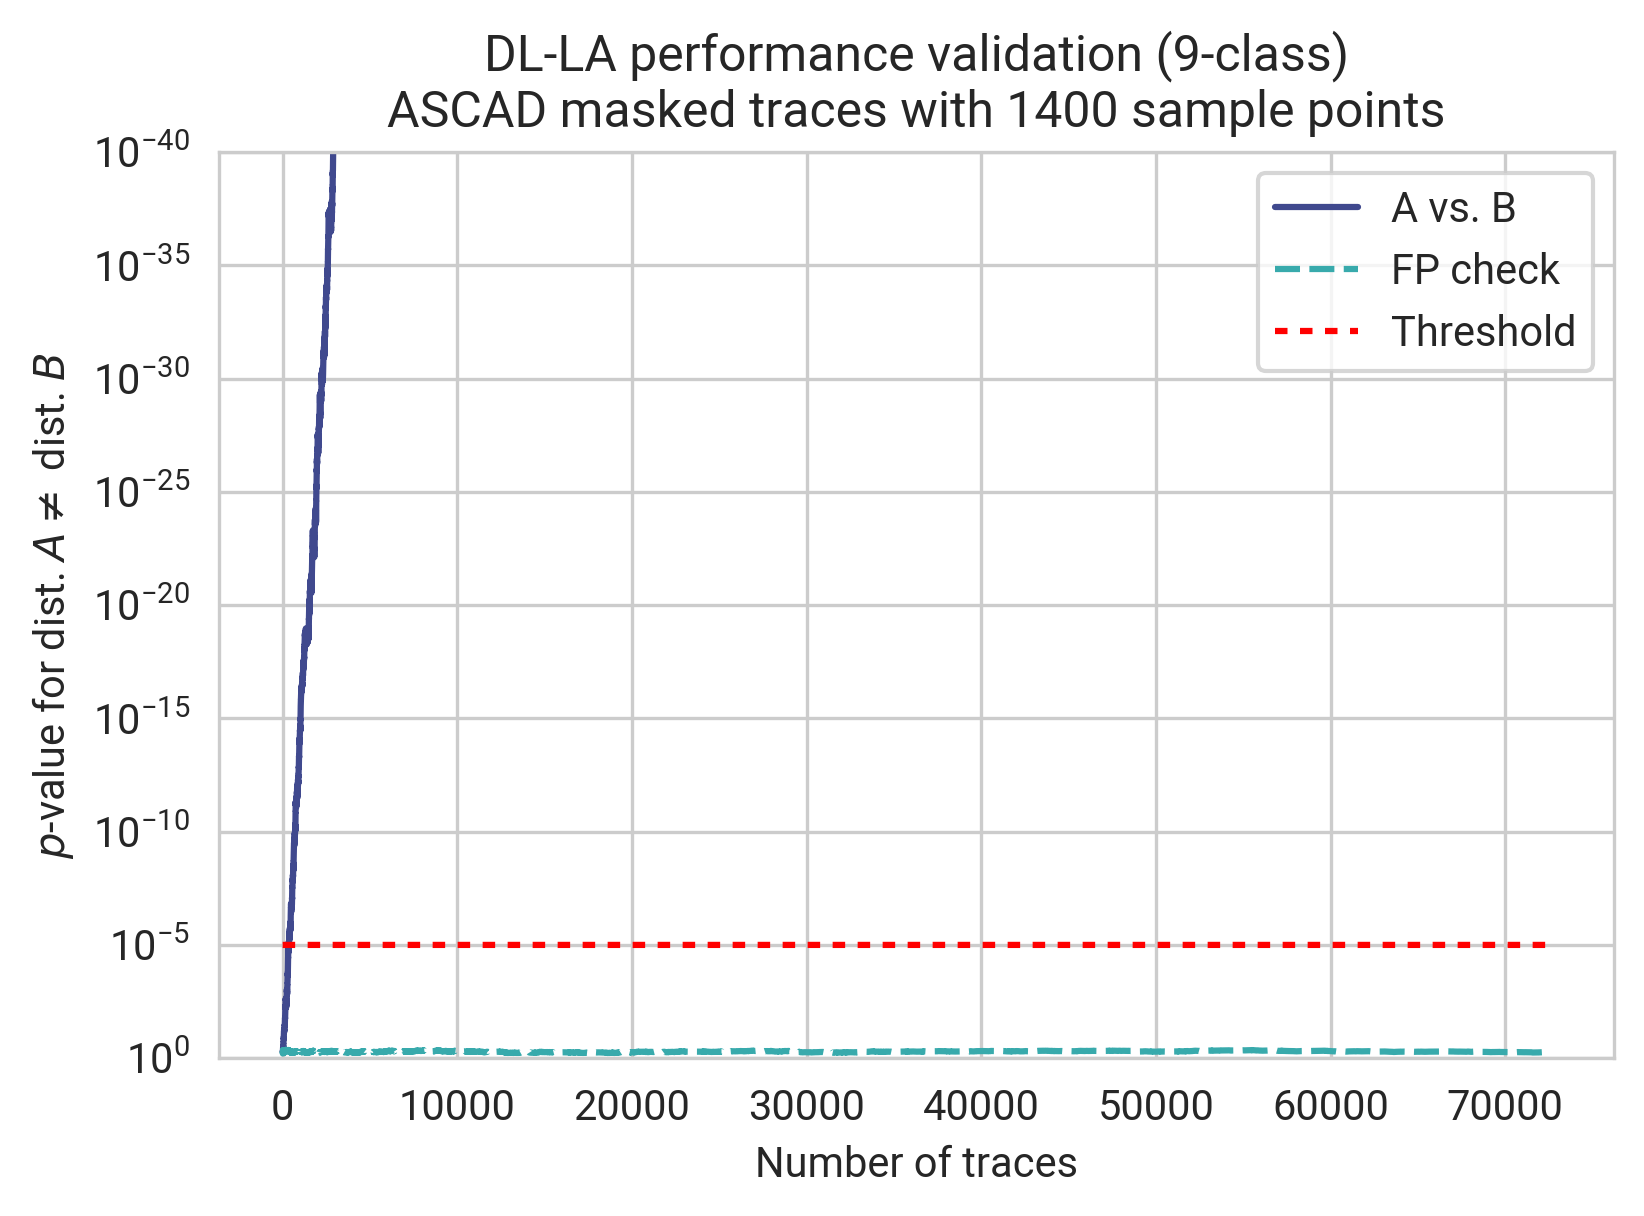

In [23]:
def make_dlla9_p_gradient(x9, y9, x9_att, y9_att, trials=REPEAT_DLLA):
    p_gradient = []

    for _ in tqdm(range(trials)):
        model_9 = make_mlp(*shuffle(x9, y9), progress=False)
        pg = dlla_p_gradient(model_9, *shuffle(x9_att, y9_att))

        p_gradient.append(pg)

    return np.mean(p_gradient, axis=0)

PG_DLLA_9 = cache_np(f"{DB.name}_dlla9_pg", make_dlla9_p_gradient, X, Y, X_ATT, Y_ATT)
PG_DLLA_9_RANDOM = cache_np(f"{DB.name}_dlla9_pg_random", make_dlla9_p_gradient, X, Y_RAND, X_ATT, Y_ATT_RAND)

plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_9),
    "FP check": np.array(PG_DLLA_9_RANDOM),
}, f"DL-LA performance validation (9-class)\n{TITLE_SUB}",
    palette=PALETTE_GRADIENT,
)

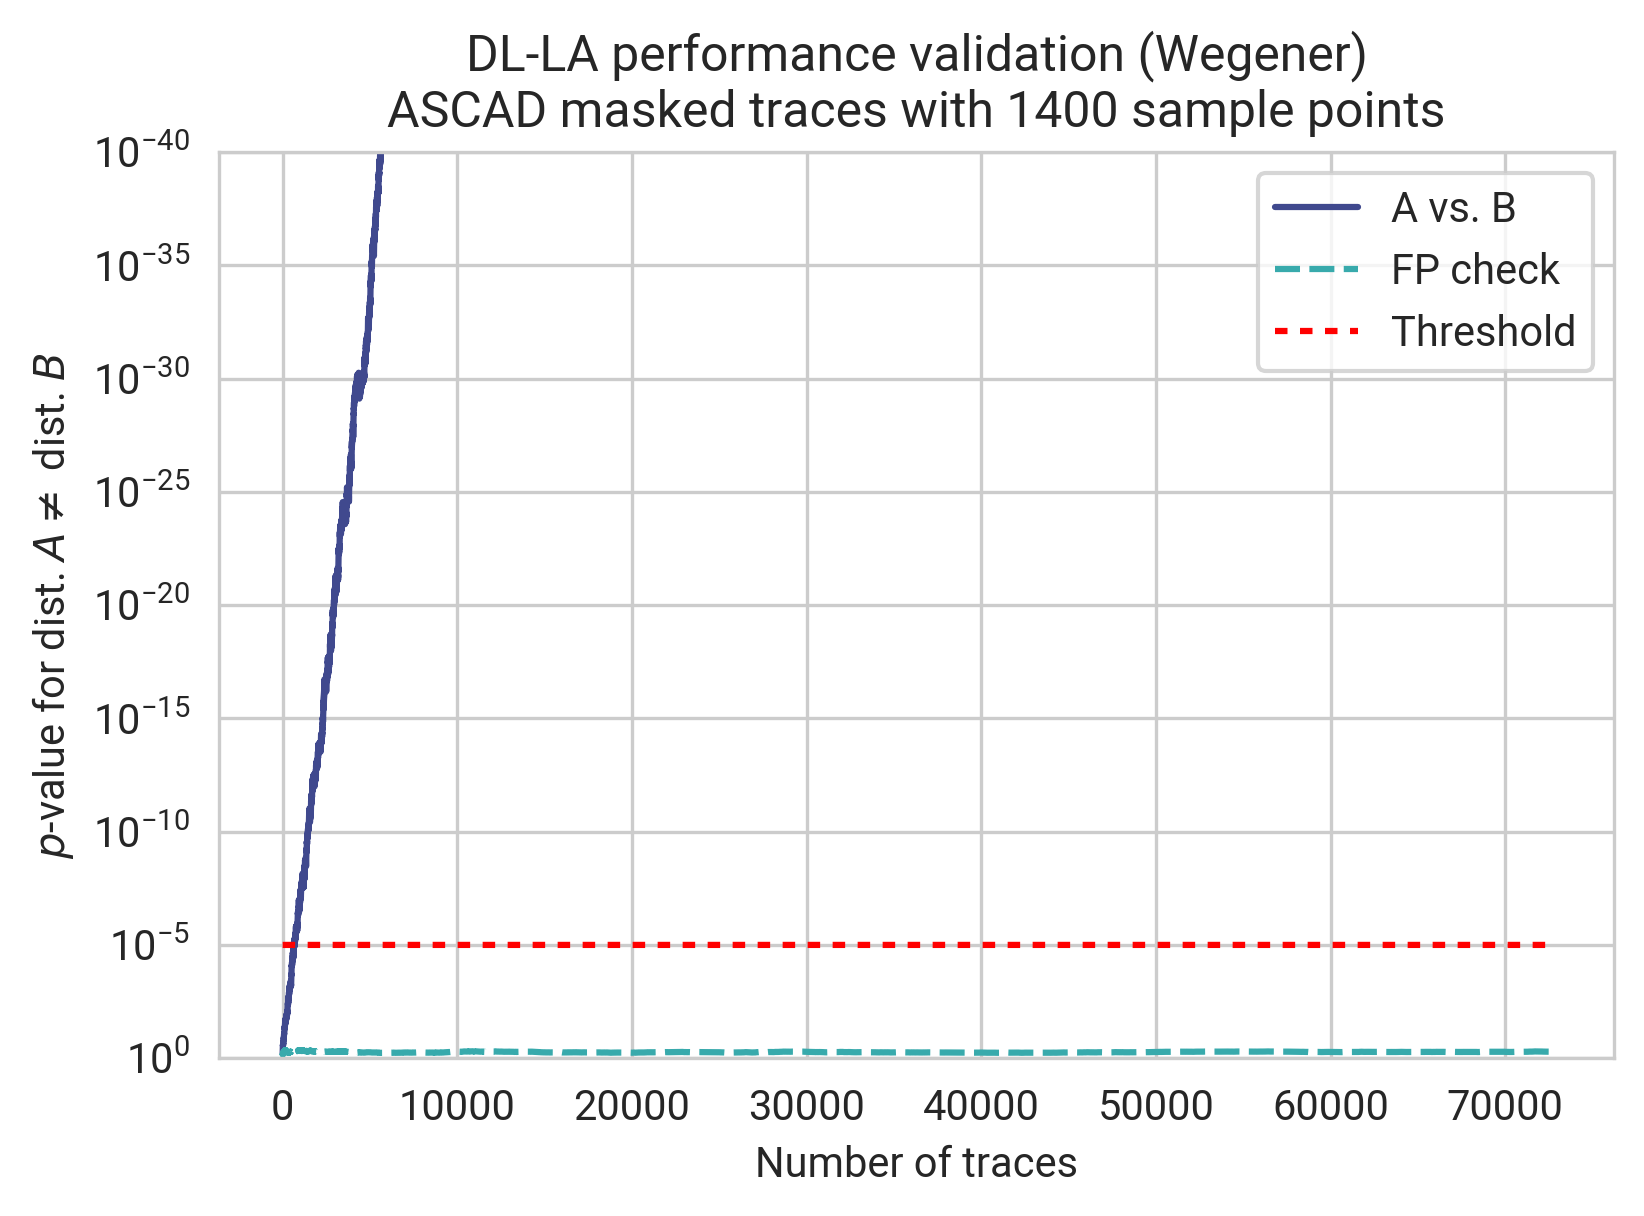

In [24]:
def make_wegener_p_gradient(x, y, x_att, y_att, trials=REPEAT_DLLA):
    p_gradient = []

    x2, y2 = reduce_fixed_fixed(x, y)
    x2_att, y2_att = reduce_fixed_fixed(x_att, y_att)

    for _ in tqdm(range(trials)):
        model_wegener = make_mlp_wegener(*shuffle(x2, y2), progress=False)
        pg = wegener_p_gradient(model_wegener, *shuffle(x2_att, y2_att))

        p_gradient.append(pg)

    return np.mean(p_gradient, axis=0)

PG_DLLA_2_AB = cache_np(f"{DB.name}_dlla2_pg", make_wegener_p_gradient, X, Y, X_ATT, Y_ATT)
PG_DLLA_2_RANDOM = cache_np(f"{DB.name}_dlla2_pg_random", make_wegener_p_gradient, X, Y_RAND, X_ATT, Y_ATT_RAND)

plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_2_AB),
    "FP check": np.array(PG_DLLA_2_RANDOM),
}, f"DL-LA performance validation (Wegener)\n{TITLE_SUB}",
    palette=PALETTE_GRADIENT,
)

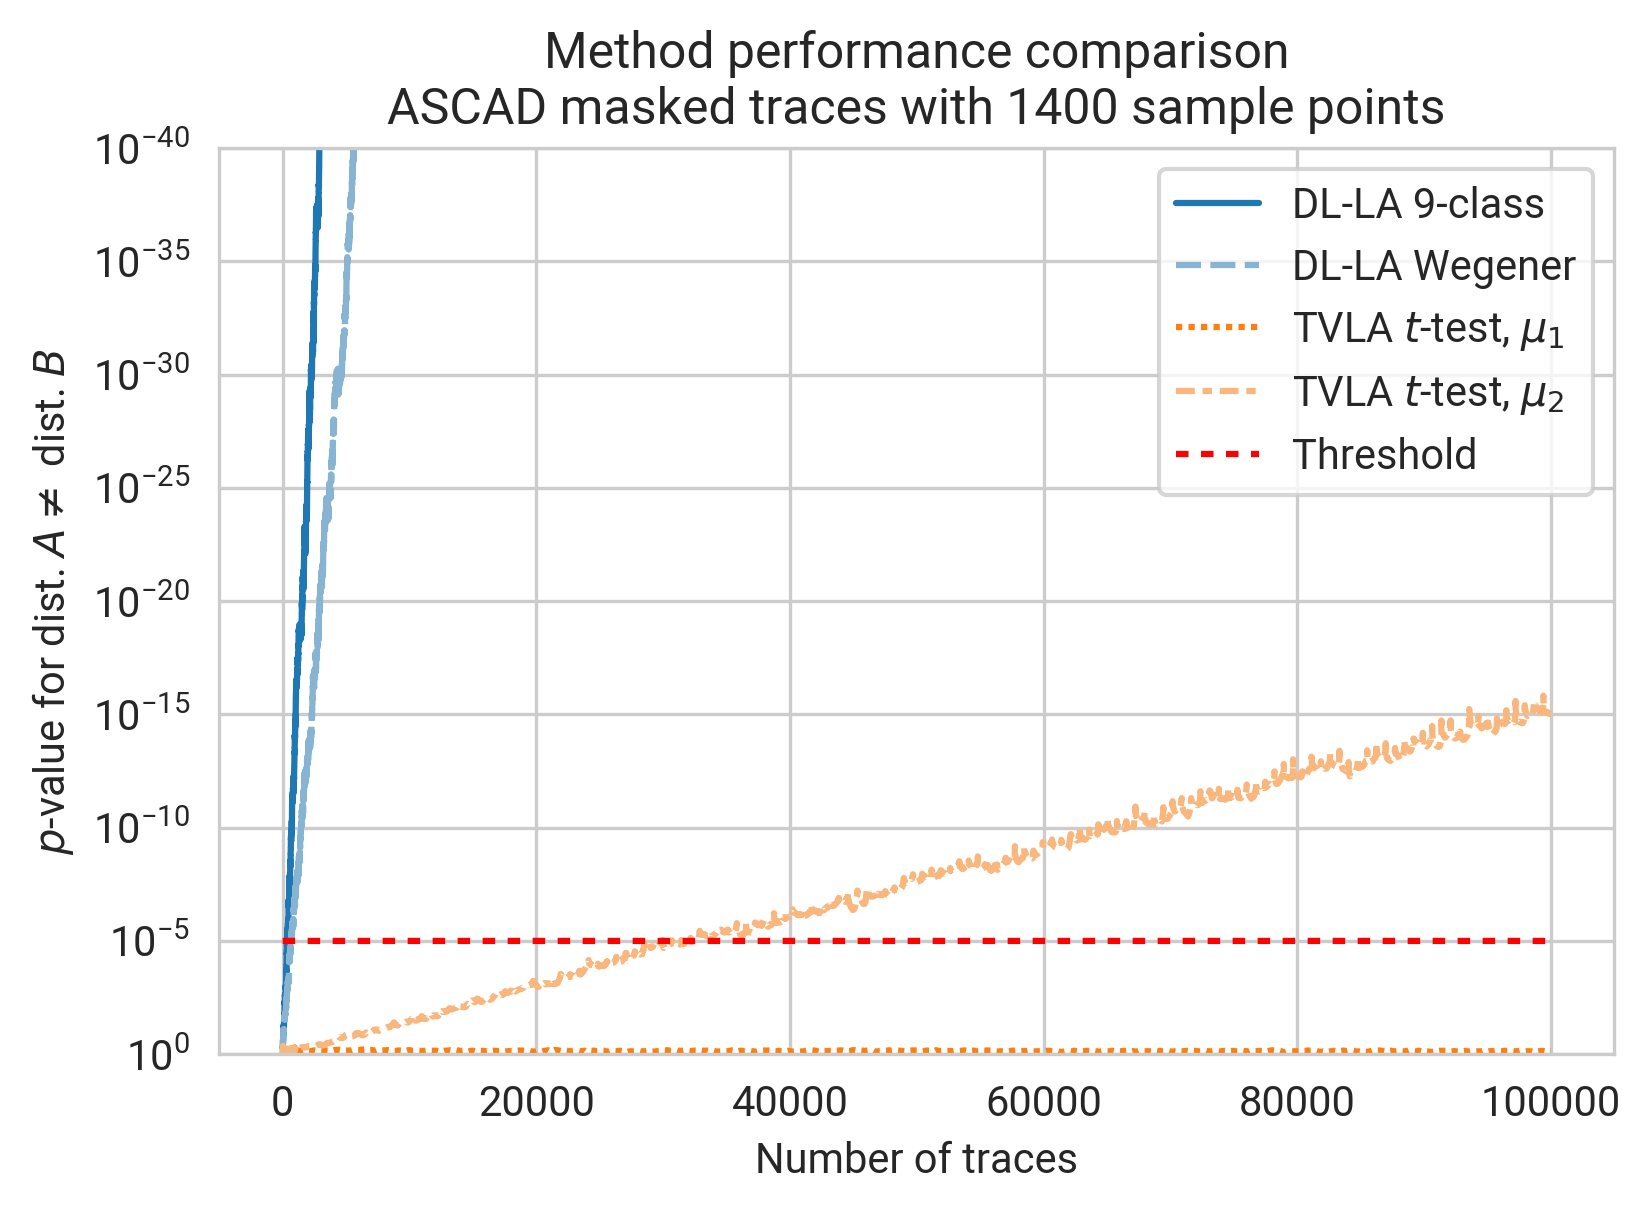

In [25]:
MAX_TRACE_SIZE = max(len(PG_DLLA_9), len(PG_DLLA_2_AB), len(TVLA_PG_T_1), len(TVLA_PG_RHO))

COLOR_PALETTE = [DLLA_PALETTE[4], DLLA_PALETTE[2], TVLA_PALETTE[4], TVLA_PALETTE[2]]

def expand(arr, max_len=MAX_TRACE_SIZE):
    return np.pad(arr, (0, max_len - len(arr)), 'constant', constant_values=np.nan)

PGS = {
    "DL-LA 9-class": expand(PG_DLLA_9)[:LIMIT],
    "DL-LA Wegener": expand(PG_DLLA_2_AB)[:LIMIT],
    "TVLA $t$-test, $\mu_1$": expand(TVLA_PG_T_1)[:LIMIT],
}

if DB is Database.ascad:
    PGS["TVLA $t$-test, $\mu_2$"] = expand(TVLA_PG_T_2)[:LIMIT]
else:
    PGS["TVLA $\\rho$-test"] = expand(TVLA_PG_RHO)[:LIMIT]

plot_p_gradient(PGS, f"Method performance comparison\n{TITLE_SUB}", file_name=f"{DB.name}-all{FILE_SUFFIX}", palette=COLOR_PALETTE)

DF = pd.DataFrame(PGS)
DF.to_csv(f"{DB.name}-p-gradients{FILE_SUFFIX}.csv")

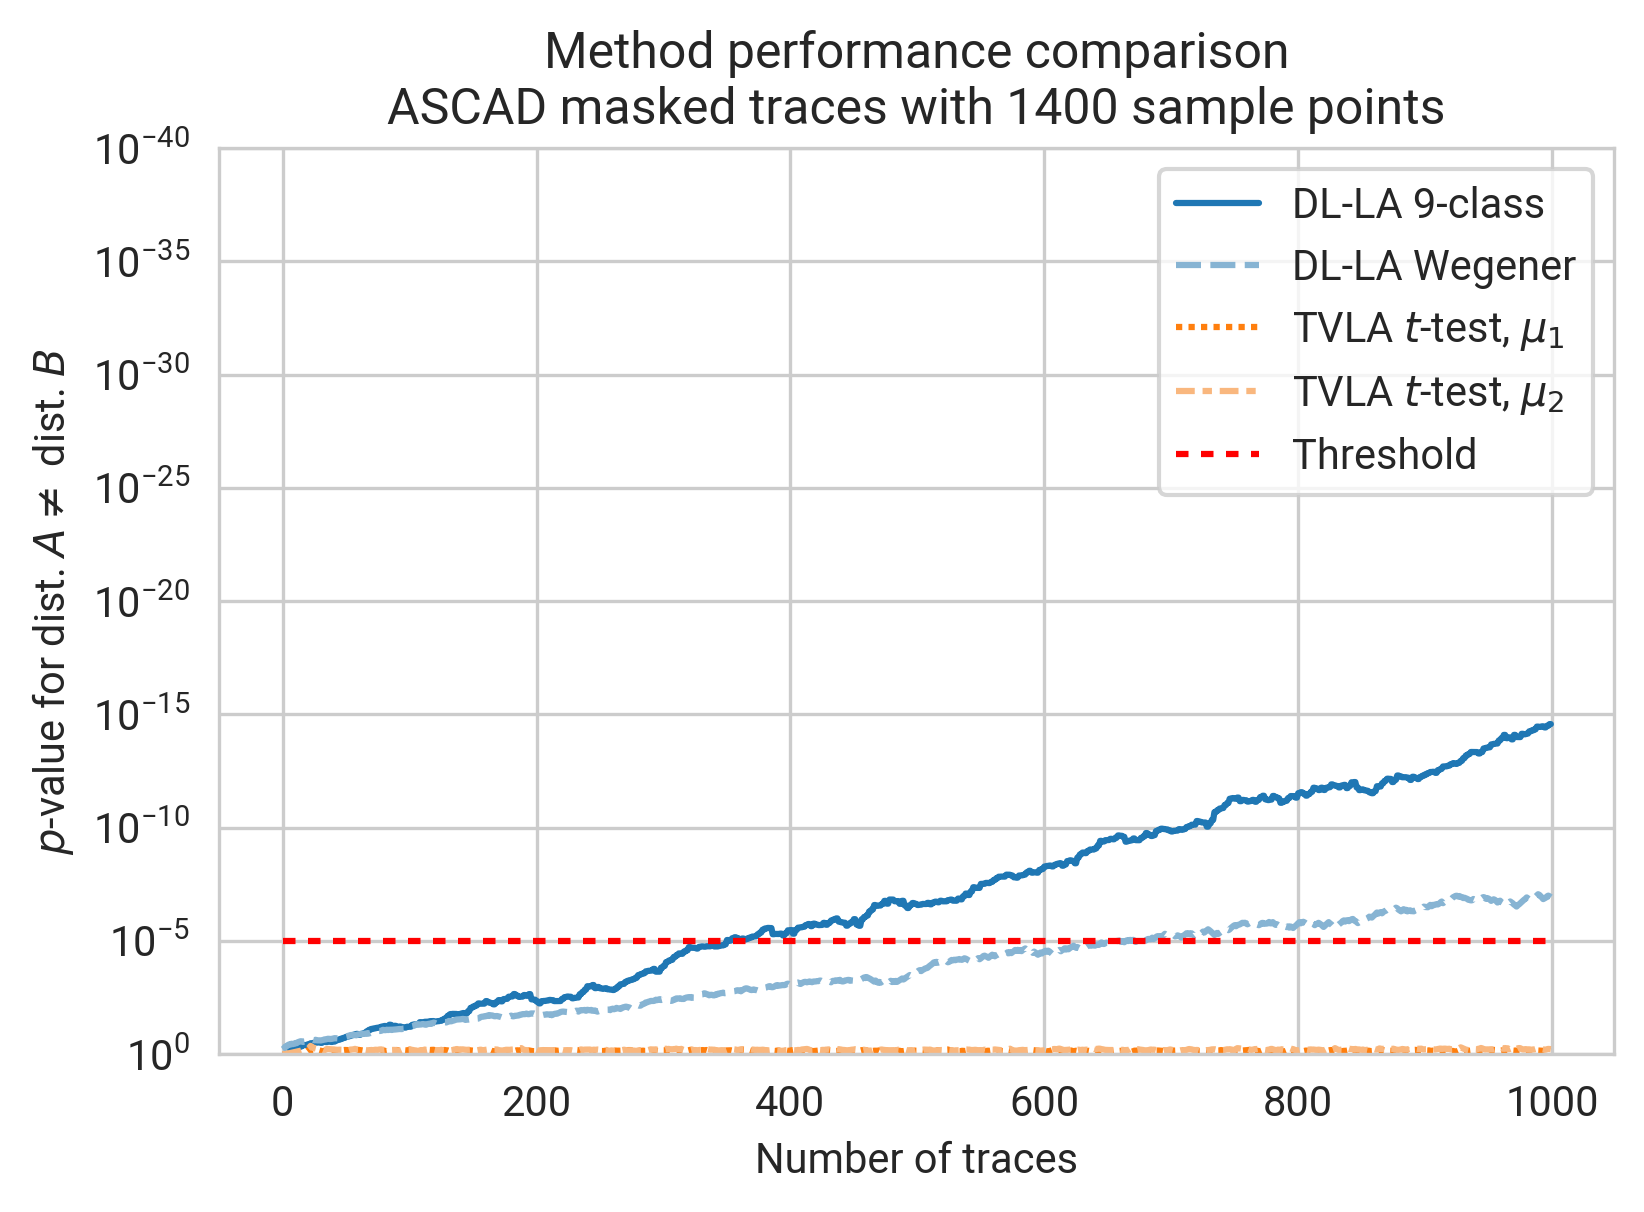

In [26]:
plot_p_gradient(PGS, f"Method performance comparison\n{TITLE_SUB}", file_name=f"{DB.name}-all{FILE_SUFFIX}-1000", palette=COLOR_PALETTE, max_traces=1000)